In [9]:
import json
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [10]:
val_csv_path = '../ham_concept_dataset/Datasets/metadata/val.csv'
predictions_json_path = '../cbm/predictions_mel_nv.json'
POSITIVE_CLASS_LABEL = 1
NEGATIVE_CLASS_LABEL = 0
POSITIVE_CLASS_NAME = "Melanoma"
NEGATIVE_CLASS_NAME = "Nevus"

In [11]:
gt_df = pd.read_csv(val_csv_path)

gt_df.dropna(subset=['image_id', 'benign_malignant'], inplace=True)
gt_df['benign_malignant'] = gt_df['benign_malignant'].astype(int)

ground_truth_map = pd.Series(gt_df.benign_malignant.values, index=gt_df.image_id).to_dict()
print(f"Loaded {len(ground_truth_map)} ground truth entries from {val_csv_path}")

Loaded 614 ground truth entries from ../ham_concept_dataset/Datasets/metadata/val.csv


In [17]:
y_true = []
y_pred = []
processed_image_ids = []
skipped_predictions_missing_gt = 0
skipped_predictions_unknown_label = 0

prediction_to_numerical = {
    "MEL": POSITIVE_CLASS_LABEL,  # Melanoma
    "NV": NEGATIVE_CLASS_LABEL    # Nevus
}

try:
    with open(predictions_json_path, 'r') as f:
        predictions_data = json.load(f)
    print(f"Loaded {len(predictions_data)} predictions from {predictions_json_path}")

    if not ground_truth_map:
        print("Warning: Ground truth map is empty. Cannot align predictions.")
    else:
        for item in predictions_data:
            image_id = item.get('image_id')
            prediction = item.get('prediction')
            true_label = ground_truth_map[image_id]
            predicted_label_numerical = prediction_to_numerical.get(prediction.upper())
                

            if predicted_label_numerical is not None:
                y_true.append(true_label)
                y_pred.append(predicted_label_numerical)
                processed_image_ids.append(image_id)
            else:
                print(f"Warning: Unknown prediction string '{prediction}' for image_id {image_id}. Skipping.")
                skipped_predictions_unknown_label += 1
        
        if skipped_predictions_missing_gt > 0:
            print(f"Warning: Skipped {skipped_predictions_missing_gt} predictions for image_ids not found in the ground truth map.")
        if skipped_predictions_unknown_label > 0:
             print(f"Warning: Skipped {skipped_predictions_unknown_label} predictions due to unknown prediction labels.")
        print(f"Successfully aligned {len(y_true)} predictions with ground truth.")

except Exception as e:
    print(f"Error: An unexpected error occurred while processing predictions: {e}")

Loaded 650 predictions from ../cbm/predictions_mel_nv.json
Successfully aligned 650 predictions with ground truth.



Evaluating 650 samples.

--- Evaluation Metrics ---
Accuracy: 0.5354

Metrics for 'Melanoma' (Class 1):
  Precision: 0.3835 (TP / (TP + FP))
  Recall (Sensitivity): 0.4515 (TP / (TP + FN))
  F1-score: 0.4147
  Specificity: 0.5835 (TN / (TN + FP) - True Negative Rate for 'Nevus')
ROC AUC: 0.5175

--- Confusion Matrix ---
Rows: True Class, Columns: Predicted Class
Labels: 0=Nevus, 1=Melanoma

                 Predicted Nevus  Predicted Melanoma
True Nevus           241              172             (FP)
True Melanoma        130             (FN)  107             (TP)

Where:
  TN (True Nevus): 241
  FP (False Melanoma): 172
  FN (False Nevus): 130
  TP (True Melanoma): 107


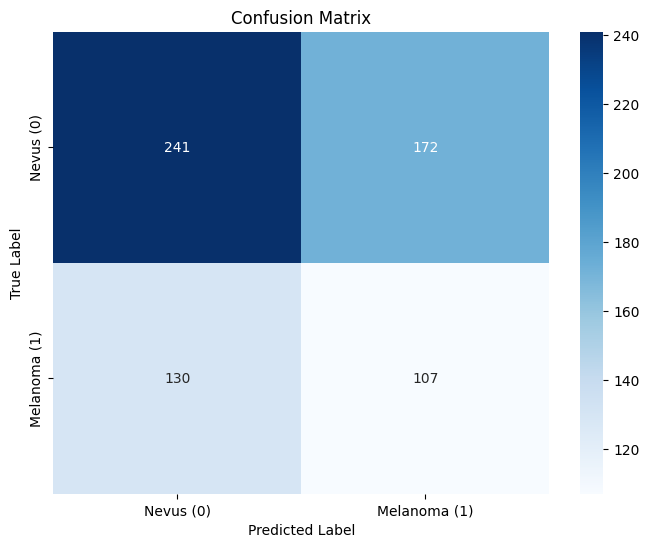

In [18]:
if not y_true or not y_pred:
    print("\nNo valid aligned predictions to evaluate.")
else:
    print(f"\nEvaluating {len(y_true)} samples.")
    
    accuracy = accuracy_score(y_true, y_pred)
    
    # Metrics for the positive class (Melanoma)
    precision_mel = precision_score(y_true, y_pred, pos_label=POSITIVE_CLASS_LABEL, zero_division=0)
    recall_mel = recall_score(y_true, y_pred, pos_label=POSITIVE_CLASS_LABEL, zero_division=0) # Also known as Sensitivity
    f1_mel = f1_score(y_true, y_pred, pos_label=POSITIVE_CLASS_LABEL, zero_division=0)
    
    # Confusion Matrix
    # Ensure labels are [Negative, Positive] for standard TN, FP, FN, TP interpretation
    cm = confusion_matrix(y_true, y_pred, labels=[NEGATIVE_CLASS_LABEL, POSITIVE_CLASS_LABEL])
    
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
    else:
        # Handle cases where confusion matrix might not be 2x2
        # (e.g., if y_true or y_pred only contains one class after filtering)
        # This setup with labels=[0,1] should generally produce a 2x2 matrix.
        # If not, it means something is very unusual with the data (e.g. only one class present in y_true AND y_pred)
        print("Warning: Confusion matrix is not 2x2. Metrics might be affected.")
        # Defaulting to prevent errors, but this indicates an issue.
        tn, fp, fn, tp = 0,0,0,0
        if NEGATIVE_CLASS_LABEL in np.unique(y_true) and POSITIVE_CLASS_LABEL not in np.unique(y_true): # Only negatives in true
            tn = cm[0,0] if cm.shape[0]>0 and cm.shape[1]>0 else 0
            fp = cm[0,1] if cm.shape[0]>0 and cm.shape[1]>1 else 0
        elif POSITIVE_CLASS_LABEL in np.unique(y_true) and NEGATIVE_CLASS_LABEL not in np.unique(y_true): # Only positives in true
            fn = cm[1,0] if cm.shape[0]>1 and cm.shape[1]>0 else 0
            tp = cm[1,1] if cm.shape[0]>1 and cm.shape[1]>1 else 0
        # This part is tricky if cm is not 2x2, but sklearn's `labels` param helps.
        # For simplicity, we'll rely on the `labels` parameter to give a 2x2 cm.
        # If it's not 2x2, it means y_true or y_pred doesn't contain both labels.
        # Let's re-assign based on the cm structure given labels=[0,1]
        tn = cm[0, 0]
        fp = cm[0, 1]
        fn = cm[1, 0]
        tp = cm[1, 1]


    # Specificity: TN / (TN + FP) - Correctly identifying Nevus
    specificity_mel = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    
    # ROC AUC Score
    # roc_auc_score can take binary predictions.
    # It might raise a ValueError if y_true contains only one class.
    roc_auc = "N/A"
    if len(np.unique(y_true)) > 1: # Check if more than one class in y_true
        try:
            roc_auc = roc_auc_score(y_true, y_pred)
        except ValueError as e:
            print(f"Could not calculate ROC AUC: {e}")
    else:
        print("ROC AUC not calculated because y_true contains only one class.")

    print("\n--- Evaluation Metrics ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"\nMetrics for '{POSITIVE_CLASS_NAME}' (Class {POSITIVE_CLASS_LABEL}):")
    print(f"  Precision: {precision_mel:.4f} (TP / (TP + FP))")
    print(f"  Recall (Sensitivity): {recall_mel:.4f} (TP / (TP + FN))")
    print(f"  F1-score: {f1_mel:.4f}")
    print(f"  Specificity: {specificity_mel:.4f} (TN / (TN + FP) - True Negative Rate for '{NEGATIVE_CLASS_NAME}')")
    
    if isinstance(roc_auc, float):
        print(f"ROC AUC: {roc_auc:.4f}")
    else:
        print(f"ROC AUC: {roc_auc}")

    print("\n--- Confusion Matrix ---")
    print(f"Rows: True Class, Columns: Predicted Class")
    print(f"Labels: 0={NEGATIVE_CLASS_NAME}, 1={POSITIVE_CLASS_NAME}\n")
    print(f"                 Predicted {NEGATIVE_CLASS_NAME}  Predicted {POSITIVE_CLASS_NAME}")
    print(f"True {NEGATIVE_CLASS_NAME:<12}    {cm[0,0]:<15}  {cm[0,1]:<15} (FP)")
    print(f"True {POSITIVE_CLASS_NAME:<12}    {cm[1,0]:<15} (FN)  {cm[1,1]:<15} (TP)")
    print(f"\nWhere:")
    print(f"  TN (True {NEGATIVE_CLASS_NAME}): {tn}")
    print(f"  FP (False {POSITIVE_CLASS_NAME}): {fp}")
    print(f"  FN (False {NEGATIVE_CLASS_NAME}): {fn}")
    print(f"  TP (True {POSITIVE_CLASS_NAME}): {tp}")

    # Visualize Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[f'{NEGATIVE_CLASS_NAME} ({NEGATIVE_CLASS_LABEL})', f'{POSITIVE_CLASS_NAME} ({POSITIVE_CLASS_LABEL})'],
                yticklabels=[f'{NEGATIVE_CLASS_NAME} ({NEGATIVE_CLASS_LABEL})', f'{POSITIVE_CLASS_NAME} ({POSITIVE_CLASS_LABEL})'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

In [19]:
if y_true:
    # Determine the majority class
    count_positive = sum(1 for label in y_true if label == POSITIVE_CLASS_LABEL)
    count_negative = len(y_true) - count_positive
    
    if count_positive > count_negative:
        majority_class_label = POSITIVE_CLASS_LABEL
        majority_class_name = POSITIVE_CLASS_NAME
    elif count_negative > count_positive:
        majority_class_label = NEGATIVE_CLASS_LABEL
        majority_class_name = NEGATIVE_CLASS_NAME
    else:
        # Handle tie by choosing one, e.g., the negative class, or print a specific message
        majority_class_label = NEGATIVE_CLASS_LABEL 
        majority_class_name = f"Either class (tie, chose {NEGATIVE_CLASS_NAME})"
        print("Note: Equal number of positive and negative samples in ground truth. Majority class baseline defaults to Negative class.")

    # Create predictions based on the majority class
    y_pred_majority = [majority_class_label] * len(y_true)
    
    # Calculate accuracy for the majority class predictor
    accuracy_majority_class = accuracy_score(y_true, y_pred_majority)
    
    print(f"\n--- Majority Class Baseline ---")
    print(f"Majority class: '{majority_class_name}' (Class {majority_class_label})")
    print(f"Number of samples: {len(y_true)}")
    print(f"  Count of '{POSITIVE_CLASS_NAME}': {count_positive}")
    print(f"  Count of '{NEGATIVE_CLASS_NAME}': {count_negative}")
    print(f"Accuracy if always predicting the majority class: {accuracy_majority_class:.4f}")
else:
    print("\nCannot calculate majority class accuracy because y_true is empty.")


--- Majority Class Baseline ---
Majority class: 'Nevus' (Class 0)
Number of samples: 650
  Count of 'Melanoma': 237
  Count of 'Nevus': 413
Accuracy if always predicting the majority class: 0.6354
